## IMPORTS

In [214]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, nsolve, log

## CONSTANTS / VARIABLES

In [215]:
D = 200 # Rotor diameter [m]
z_h = 100 # hub height [m]
s_x = 10 # Streamwise distance [D]
s_y = 10 # Transverse distance [D]
n_d_turbine = 9 # Number of turbine rows [-]
n_t_turbine = 9 # Number of turbines per row [-]
#U_G = 14.41 # 12 Uh0
U_G = 11.87 # 10 Uh0

delta_ibl_0 = z_h

C = 4.0 # Empirical constant [-]
C_star = 4.5 # Friction velocity constant [-]

f = 1*10**(-4) # Coriolis parameter [1/s]
k = 0.4 # Von Karman constant [-]

C_T = 0.8 # Thrust coefficient [-]
C_P = 0.4 # Power coefficient [-]

rho = 1.2 # Air density [kg/m^3]
z_0lo = 0.0001 # surface rughness length [m] 

## MODEL CONSTANT ALCULATIONS

In [216]:
ct = (np.pi * C_T * D**2)/(8 * s_x*D * s_y*D)
print('Scaled Thrust Coefficient: ', round(ct, 5), '[-]')

nu_star = 28 * np.sqrt(ct)
print('Eddy Viscosity: ', round(nu_star, 2), '[-]')

beta =  nu_star / (1 + nu_star)
print('Wake Expansion Parameter: ', round(beta, 2), '[-]')

z_0hi = z_h * (1 + D/(2 * z_h))**beta * np.exp(-(ct/(2 * k**2) + (np.log(z_h / z_0lo * (1 - D/(2 * z_h))**beta))**-2)**-0.5)
print("Effective Roughness Height z0_:hi: ", round(z_0hi, 4), "m")

u_star_lo = (k * U_G) / (np.log(U_G / (f * z_0lo)) - C_star)
print("Friction Velocity lo: ", round(u_star_lo, 4), "m/s")

u_star_hi = (k * U_G) / (np.log(U_G / (f * z_0hi)) - C_star)
print("Friction Velocity hi: ", round(u_star_hi, 4), "m/s")

U_h0 = u_star_lo / k * np.log(z_h / z_0lo)
print('Unperturbed Wind Speed: ', round(U_h0, 2), 'm/s')

z0_WF = z_h * (1 + D/(2 * z_h))**beta * np.exp(-k * (ct + (k/np.log((z_h / z_0lo) * (1 - D/(2 * z_h))**beta))**2)**-0.5)
print('Effective Roughness Height z0_WF: ', round(z0_WF, 4), 'm')

Scaled Thrust Coefficient:  0.00314 [-]
Eddy Viscosity:  1.57 [-]
Wake Expansion Parameter:  0.61 [-]
Effective Roughness Height z0_:hi:  0.0063 m
Friction Velocity lo:  0.2896 m/s
Friction Velocity hi:  0.3876 m/s
Unperturbed Wind Speed:  10.0 m/s
Effective Roughness Height z0_WF:  0.1215 m


/var/folders/j6/19hd1bln7bx6375t_4njz15w0000gn/T/ipykernel_11958/1126335692.py:10: RuntimeWarning: divide by zero encountered in log
  z_0hi = z_h * (1 + D/(2 * z_h))**beta * np.exp(-(ct/(2 * k**2) + (np.log(z_h / z_0lo * (1 - D/(2 * z_h))**beta))**-2)**-0.5)
/var/folders/j6/19hd1bln7bx6375t_4njz15w0000gn/T/ipykernel_11958/1126335692.py:22: RuntimeWarning: divide by zero encountered in log
  z0_WF = z_h * (1 + D/(2 * z_h))**beta * np.exp(-k * (ct + (k/np.log((z_h / z_0lo) * (1 - D/(2 * z_h))**beta))**2)**-0.5)


## NYGAARD MODEL SETUP

/var/folders/j6/19hd1bln7bx6375t_4njz15w0000gn/T/ipykernel_11958/3018136803.py:24: RuntimeWarning: invalid value encountered in power
  h2_park = z_t_park + z0_WF * ((x_park-x2)/z0_WF)**(4/5)


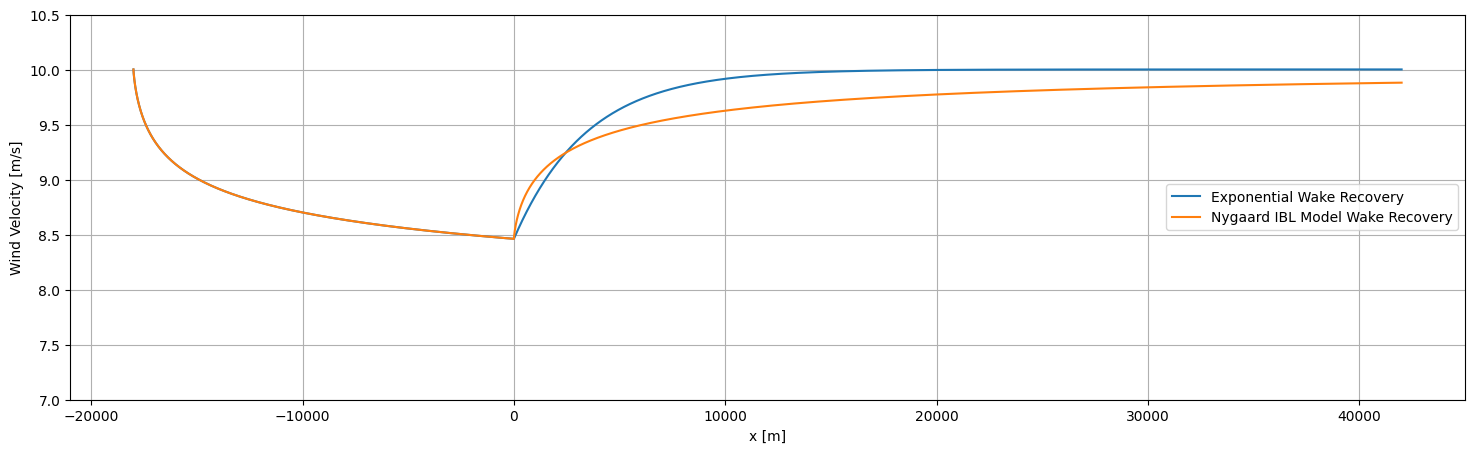

9.84904345280789

10.002487173254785


In [217]:
# Park length definition
L_park = n_d_turbine * D * s_x
L_wake = 60000

# Park start x-coordinate and wake recovery start x-coordinate
x1 = 0
x2 = L_park


# Create x-arrays for the park and wake recovery region
x_park = np.linspace(x1, L_park, L_park)
x_wake = np.linspace(L_park, L_wake, L_wake-L_park)
x_zt = np.linspace(x1, L_wake, L_wake)


# Create transition values for initial IBL height in the park and wake recovery region
z_t = z_h * np.exp(-10 * x_zt / max(x_zt)) + z_0lo * (1 - np.exp(-10 * x_zt / max(x_zt)))
z_t_park = z_t[0:L_park]
z_t_wake = z_t[0:L_wake-L_park]


# Define the IBL height for the park and wake recovery region
h1_park = z_h + z0_WF * ((x_park-x1)/z0_WF)**(4/5)
h2_park = z_t_park + z0_WF * ((x_park-x2)/z0_WF)**(4/5)

h1_wake = z_h + z0_WF * ((x_wake-x1)/z0_WF)**(4/5)
h2_wake = z_t_wake + z0_WF * ((x_wake-x2)/z0_WF)**(4/5)


# Deficit function U(x) for the park region using Nygaard Model
U_park_deficit = U_h0 * (np.log(h1_park/z_0lo) * np.log(z_h/z0_WF)) / (np.log(h1_park/z0_WF) * np.log(z_h/z_0lo))


# Wake recovery function U(x) for the wake recovery region using Nygaard Model
U_wake_recovery = U_h0 * (np.log(h1_wake/z_0lo) * np.log(h2_wake/z0_WF)) / (np.log(h1_wake/z0_WF) * np.log(h2_wake/z_0lo))


# Nygaard Model
U_nygaard = np.concatenate((U_park_deficit, U_wake_recovery))
x_nygaard = np.linspace(x1, len(U_nygaard), len(U_nygaard))

# Exponenial Recovery Model
# Define Fully Developed Wind Speed at the hub height as U_d
U_d = min(U_park_deficit)
a = k * u_star_lo * z_h/(2*z_h)**2

U_wake_recovery_exponential = U_h0 + U_h0 * ((U_d)/(U_h0)-1) * np.exp(-a*(x_wake-L_park))

# Nygaard Model
U_nygaard_exponential_recovery = np.concatenate((U_park_deficit, U_wake_recovery_exponential))
x_nygaard = np.linspace(x1, len(U_nygaard_exponential_recovery), len(U_nygaard_exponential_recovery)) - L_park

# Plot the deficit function U_park_deficit
plt.figure(figsize=(18, 5))
plt.plot(x_nygaard, U_nygaard_exponential_recovery, label='Exponential Wake Recovery')
plt.plot(x_nygaard, U_nygaard, label='Nygaard IBL Model Wake Recovery')
plt.xlabel('x [m]')
plt.ylabel('Wind Velocity [m/s]')
plt.ylim(7, 10.5)
#plt.title('Wind Velocity Deficit and recover in the Park and Wake Recovery Region')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

print(U_wake_recovery[32000])
print()
print(U_wake_recovery_exponential[32000])

## IMPLEMENTATION GRAPH FOR RAPPORT

In [218]:
"""
D = 150 # Rotor diameter [m]
z_h = 100 # hub height [m]
s_x = 7 # Streamwise distance [D]
s_y = 7 # Transverse distance [D]
n_d_turbine = 9 # Number of turbine rows [-]
n_t_turbine = 9 # Number of turbines per row [-]
U_G = 11.87

delta_ibl_0 = z_h

C = 4.0 # Empirical constant [-]
C_star = 4.5 # Friction velocity constant [-]

f = 1*10**(-4) # Coriolis parameter [1/s]
k = 0.4 # Von Karman constant [-]

C_T = 0.8 # Thrust coefficient [-]
C_P = 0.4 # Power coefficient [-]

rho = 1.2 # Air density [kg/m^3]
z_0lo = 0.0001 # surface rughness length [m] 

ct = (np.pi * C_T * D**2)/(8 * s_x*D * s_y*D)

nu_star = 28 * np.sqrt(ct)

beta =  nu_star / (1 + nu_star)

z_0hi = z_h * (1 + D/(2 * z_h))**beta * np.exp(-(ct/(2 * k**2) + (np.log(z_h / z_0lo * (1 - D/(2 * z_h))**beta))**-2)**-0.5)

u_star_lo = (k * U_G) / (np.log(U_G / (f * z_0lo)) - C_star)

u_star_hi = (k * U_G) / (np.log(U_G / (f * z_0hi)) - C_star)

U_h0 = u_star_lo / k * np.log(z_h / z_0lo)
print('Unperturbed Wind Speed: ', round(U_h0, 2), 'm/s')

z0_WF = z_h * (1 + D/(2 * z_h))**beta * np.exp(-k * (ct + (k/np.log((z_h / z_0lo) * (1 - D/(2 * z_h))**beta))**2)**-0.5)

# Park length definition
L_park = 10000
L_wake = 40000

# Park start x-coordinate and wake recovery start x-coordinate
x1 = 0
x2 = L_park


# Create x-arrays for the park and wake recovery region
x_park = np.linspace(x1, L_park, L_park)
x_wake = np.linspace(L_park, L_wake, L_wake-L_park)
x_zt = np.linspace(x1, L_wake, L_wake)


# Create transition values for initial IBL height in the park and wake recovery region
z_t = z_h * np.exp(-10 * x_zt / max(x_zt)) + z_0lo * (1 - np.exp(-10 * x_zt / max(x_zt)))
z_t_park = z_t[0:L_park]
z_t_wake = z_t[0:L_wake-L_park]


# Define the IBL height for the park and wake recovery region
h1_park = z_h + z0_WF * ((x_park-x1)/z0_WF)**(4/5)
h2_park = z_t_park + z0_WF * ((x_park-x2)/z0_WF)**(4/5)

h1_wake = z_h + z0_WF * ((x_wake-x1)/z0_WF)**(4/5)
h2_wake = z_t_wake + z0_WF * ((x_wake-x2)/z0_WF)**(4/5)


# Deficit function U(x) for the park region using Nygaard Model
U_park_deficit = U_h0 * (np.log(h1_park/z_0lo) * np.log(z_h/z0_WF)) / (np.log(h1_park/z0_WF) * np.log(z_h/z_0lo))


# Wake recovery function U(x) for the wake recovery region using Nygaard Model
U_wake_recovery = U_h0 * (np.log(h1_wake/z_0lo) * np.log(h2_wake/z0_WF)) / (np.log(h1_wake/z0_WF) * np.log(h2_wake/z_0lo))


# Nygaard Model
U_nygaard = np.concatenate((U_park_deficit, U_wake_recovery))
x_nygaard = np.linspace(x1, len(U_nygaard), len(U_nygaard))


s_x = 8 # Streamwise distance [D]
s_y = 8 # Transverse distance [D]

ct = (np.pi * C_T * D**2)/(8 * s_x*D * s_y*D)

nu_star = 28 * np.sqrt(ct)

beta =  nu_star / (1 + nu_star)

z_0hi = z_h * (1 + D/(2 * z_h))**beta * np.exp(-(ct/(2 * k**2) + (np.log(z_h / z_0lo * (1 - D/(2 * z_h))**beta))**-2)**-0.5)

u_star_lo = (k * U_G) / (np.log(U_G / (f * z_0lo)) - C_star)

u_star_hi = (k * U_G) / (np.log(U_G / (f * z_0hi)) - C_star)

U_h0 = u_star_lo / k * np.log(z_h / z_0lo)

z0_WF = z_h * (1 + D/(2 * z_h))**beta * np.exp(-k * (ct + (k/np.log((z_h / z_0lo) * (1 - D/(2 * z_h))**beta))**2)**-0.5)

# Park length definition
L_park = 10000
L_wake = 40000

# Park start x-coordinate and wake recovery start x-coordinate
x1 = 0
x2 = L_park


# Create x-arrays for the park and wake recovery region
x_park = np.linspace(x1, L_park, L_park)
x_wake = np.linspace(L_park, L_wake, L_wake-L_park)
x_zt = np.linspace(x1, L_wake, L_wake)


# Create transition values for initial IBL height in the park and wake recovery region
z_t = z_h * np.exp(-10 * x_zt / max(x_zt)) + z_0lo * (1 - np.exp(-10 * x_zt / max(x_zt)))
z_t_park = z_t[0:L_park]
z_t_wake = z_t[0:L_wake-L_park]


# Define the IBL height for the park and wake recovery region
h1_park = z_h + z0_WF * ((x_park-x1)/z0_WF)**(4/5)
h2_park = z_t_park + z0_WF * ((x_park-x2)/z0_WF)**(4/5)

h1_wake = z_h + z0_WF * ((x_wake-x1)/z0_WF)**(4/5)
h2_wake = z_t_wake + z0_WF * ((x_wake-x2)/z0_WF)**(4/5)


# Deficit function U(x) for the park region using Nygaard Model
U_park_deficit = U_h0 * (np.log(h1_park/z_0lo) * np.log(z_h/z0_WF)) / (np.log(h1_park/z0_WF) * np.log(z_h/z_0lo))


# Wake recovery function U(x) for the wake recovery region using Nygaard Model
U_wake_recovery = U_h0 * (np.log(h1_wake/z_0lo) * np.log(h2_wake/z0_WF)) / (np.log(h1_wake/z0_WF) * np.log(h2_wake/z_0lo))


# Nygaard Model
U_nygaard1 = np.concatenate((U_park_deficit, U_wake_recovery))
x_nygaard1 = np.linspace(x1, len(U_nygaard), len(U_nygaard))


s_x = 9 # Streamwise distance [D]
s_y = 9 # Transverse distance [D]

ct = (np.pi * C_T * D**2)/(8 * s_x*D * s_y*D)

nu_star = 28 * np.sqrt(ct)

beta =  nu_star / (1 + nu_star)

z_0hi = z_h * (1 + D/(2 * z_h))**beta * np.exp(-(ct/(2 * k**2) + (np.log(z_h / z_0lo * (1 - D/(2 * z_h))**beta))**-2)**-0.5)

u_star_lo = (k * U_G) / (np.log(U_G / (f * z_0lo)) - C_star)

u_star_hi = (k * U_G) / (np.log(U_G / (f * z_0hi)) - C_star)

U_h0 = u_star_lo / k * np.log(z_h / z_0lo)

z0_WF = z_h * (1 + D/(2 * z_h))**beta * np.exp(-k * (ct + (k/np.log((z_h / z_0lo) * (1 - D/(2 * z_h))**beta))**2)**-0.5)

# Park length definition
L_park = 10000
L_wake = 40000

# Park start x-coordinate and wake recovery start x-coordinate
x1 = 0
x2 = L_park


# Create x-arrays for the park and wake recovery region
x_park = np.linspace(x1, L_park, L_park)
x_wake = np.linspace(L_park, L_wake, L_wake-L_park)
x_zt = np.linspace(x1, L_wake, L_wake)


# Create transition values for initial IBL height in the park and wake recovery region
z_t = z_h * np.exp(-10 * x_zt / max(x_zt)) + z_0lo * (1 - np.exp(-10 * x_zt / max(x_zt)))
z_t_park = z_t[0:L_park]
z_t_wake = z_t[0:L_wake-L_park]


# Define the IBL height for the park and wake recovery region
h1_park = z_h + z0_WF * ((x_park-x1)/z0_WF)**(4/5)
h2_park = z_t_park + z0_WF * ((x_park-x2)/z0_WF)**(4/5)

h1_wake = z_h + z0_WF * ((x_wake-x1)/z0_WF)**(4/5)
h2_wake = z_t_wake + z0_WF * ((x_wake-x2)/z0_WF)**(4/5)


# Deficit function U(x) for the park region using Nygaard Model
U_park_deficit = U_h0 * (np.log(h1_park/z_0lo) * np.log(z_h/z0_WF)) / (np.log(h1_park/z0_WF) * np.log(z_h/z_0lo))


# Wake recovery function U(x) for the wake recovery region using Nygaard Model
U_wake_recovery = U_h0 * (np.log(h1_wake/z_0lo) * np.log(h2_wake/z0_WF)) / (np.log(h1_wake/z0_WF) * np.log(h2_wake/z_0lo))


# Nygaard Model
U_nygaard2 = np.concatenate((U_park_deficit, U_wake_recovery))
x_nygaard2 = np.linspace(x1, len(U_nygaard), len(U_nygaard))



s_x = 10 # Streamwise distance [D]
s_y = 10 # Transverse distance [D]


ct = (np.pi * C_T * D**2)/(8 * s_x*D * s_y*D)

nu_star = 28 * np.sqrt(ct)

beta =  nu_star / (1 + nu_star)

z_0hi = z_h * (1 + D/(2 * z_h))**beta * np.exp(-(ct/(2 * k**2) + (np.log(z_h / z_0lo * (1 - D/(2 * z_h))**beta))**-2)**-0.5)

u_star_lo = (k * U_G) / (np.log(U_G / (f * z_0lo)) - C_star)

u_star_hi = (k * U_G) / (np.log(U_G / (f * z_0hi)) - C_star)

U_h0 = u_star_lo / k * np.log(z_h / z_0lo)

z0_WF = z_h * (1 + D/(2 * z_h))**beta * np.exp(-k * (ct + (k/np.log((z_h / z_0lo) * (1 - D/(2 * z_h))**beta))**2)**-0.5)

# Park length definition
L_park = 10000
L_wake = 40000

# Park start x-coordinate and wake recovery start x-coordinate
x1 = 0
x2 = L_park


# Create x-arrays for the park and wake recovery region
x_park = np.linspace(x1, L_park, L_park)
x_wake = np.linspace(L_park, L_wake, L_wake-L_park)
x_zt = np.linspace(x1, L_wake, L_wake)


# Create transition values for initial IBL height in the park and wake recovery region
z_t = z_h * np.exp(-10 * x_zt / max(x_zt)) + z_0lo * (1 - np.exp(-10 * x_zt / max(x_zt)))
z_t_park = z_t[0:L_park]
z_t_wake = z_t[0:L_wake-L_park]


# Define the IBL height for the park and wake recovery region
h1_park = z_h + z0_WF * ((x_park-x1)/z0_WF)**(4/5)
h2_park = z_t_park + z0_WF * ((x_park-x2)/z0_WF)**(4/5)

h1_wake = z_h + z0_WF * ((x_wake-x1)/z0_WF)**(4/5)
h2_wake = z_t_wake + z0_WF * ((x_wake-x2)/z0_WF)**(4/5)


# Deficit function U(x) for the park region using Nygaard Model
U_park_deficit = U_h0 * (np.log(h1_park/z_0lo) * np.log(z_h/z0_WF)) / (np.log(h1_park/z0_WF) * np.log(z_h/z_0lo))


# Wake recovery function U(x) for the wake recovery region using Nygaard Model
U_wake_recovery = U_h0 * (np.log(h1_wake/z_0lo) * np.log(h2_wake/z0_WF)) / (np.log(h1_wake/z0_WF) * np.log(h2_wake/z_0lo))


# Nygaard Model
U_nygaard3 = np.concatenate((U_park_deficit, U_wake_recovery))
x_nygaard3 = np.linspace(x1, len(U_nygaard), len(U_nygaard))

# Adjust x-axis to start from where the wake begins (x = 10000 becomes x = 0)
x_nygaard = x_nygaard - 10000
x_nygaard1 = x_nygaard1 - 10000
x_nygaard2 = x_nygaard2 - 10000
x_nygaard3 = x_nygaard3 - 10000

# Plot the data with the adjusted x-axis
plt.figure(figsize=(18, 5))  # Set the figure size to make it wider
plt.plot(x_nygaard, U_nygaard, '--', linewidth=2, label='s = 7D', color='#1f77b4')
plt.plot(x_nygaard1, U_nygaard1, '--', linewidth=2, label='s = 8D', color='#ff7f0e')
plt.plot(x_nygaard2, U_nygaard2, '--', linewidth=2, label='s = 9D', color='#2ca02c')
plt.plot(x_nygaard3, U_nygaard3, '--', linewidth=2, label='s = 10D', color='#d62728')

min_value_7D = U_nygaard.min() + 0.15
min_index_7D = U_nygaard.argmin() + 500
min_x_7D = x_nygaard[min_index_7D]
plt.text(min_x_7D, min_value_7D - 0.2, f"Min: {min_value_7D:.2f} m/s", 
         fontsize=14, color='#1f77b4', bbox=dict(facecolor='white', edgecolor='#1f77b4', boxstyle='round,pad=0.3'))

min_value_8D = U_nygaard1.min() + 0.1
min_index_8D = U_nygaard1.argmin() + 700
min_x_8D = x_nygaard1[min_index_8D]
plt.text(min_x_8D, min_value_8D - 0.2, f"Min: {min_value_8D:.2f} m/s", 
         fontsize=14, color='#ff7f0e', bbox=dict(facecolor='white', edgecolor='#ff7f0e', boxstyle='round,pad=0.3'))

min_value_9D = U_nygaard2.min() + 0.1
min_index_9D = U_nygaard2.argmin() + 900
min_x_9D = x_nygaard2[min_index_9D]
plt.text(min_x_9D, min_value_9D - 0.2, f"Min: {min_value_9D:.2f} m/s", 
         fontsize=14, color='#2ca02c', bbox=dict(facecolor='white', edgecolor='#2ca02c', boxstyle='round,pad=0.3'))

min_value_10D = U_nygaard3.min() + 0.15
min_index_10D = U_nygaard3.argmin() + 1100
min_x_10D = x_nygaard3[min_index_10D]
plt.text(min_x_10D, min_value_10D - 0.2, f"Min: {min_value_10D:.2f} m/s", 
         fontsize=14, color='#d62728', bbox=dict(facecolor='white', edgecolor='#d62728', boxstyle='round,pad=0.3'))

# Add a dotted line for the freeflow wind velocity
plt.axhline(y=U_h0, color='grey', linestyle='solid', linewidth=4, label='Uh0')
plt.xlabel('Downstream Distance: x [km]', fontsize=16)  # Increase font size for x-axis label
plt.ylabel('Hubheight Wind Velocity: Ux [m/s]', fontsize=16)  # Increase font size for y-axis label
#plt.title('\n\nNygaard & Newcombe [2018] IBL TDM with IBL Recovery\n\n', fontsize=24, weight='bold')  # Add whitespace and bold title
plt.xticks(fontsize=14)  # Increase font size for x-axis tick labels
plt.yticks(fontsize=14)  # Increase font size for y-axis tick labels
plt.legend(fontsize=14, loc='lower right')  # Move the legend to the bottom right
plt.ylim(7, 10.5)
plt.grid(True)
plt.show()
"""

'\nD = 150 # Rotor diameter [m]\nz_h = 100 # hub height [m]\ns_x = 7 # Streamwise distance [D]\ns_y = 7 # Transverse distance [D]\nn_d_turbine = 9 # Number of turbine rows [-]\nn_t_turbine = 9 # Number of turbines per row [-]\nU_G = 11.87\n\ndelta_ibl_0 = z_h\n\nC = 4.0 # Empirical constant [-]\nC_star = 4.5 # Friction velocity constant [-]\n\nf = 1*10**(-4) # Coriolis parameter [1/s]\nk = 0.4 # Von Karman constant [-]\n\nC_T = 0.8 # Thrust coefficient [-]\nC_P = 0.4 # Power coefficient [-]\n\nrho = 1.2 # Air density [kg/m^3]\nz_0lo = 0.0001 # surface rughness length [m] \n\nct = (np.pi * C_T * D**2)/(8 * s_x*D * s_y*D)\n\nnu_star = 28 * np.sqrt(ct)\n\nbeta =  nu_star / (1 + nu_star)\n\nz_0hi = z_h * (1 + D/(2 * z_h))**beta * np.exp(-(ct/(2 * k**2) + (np.log(z_h / z_0lo * (1 - D/(2 * z_h))**beta))**-2)**-0.5)\n\nu_star_lo = (k * U_G) / (np.log(U_G / (f * z_0lo)) - C_star)\n\nu_star_hi = (k * U_G) / (np.log(U_G / (f * z_0hi)) - C_star)\n\nU_h0 = u_star_lo / k * np.log(z_h / z_0lo)\nprin

## Wake Expansion Model

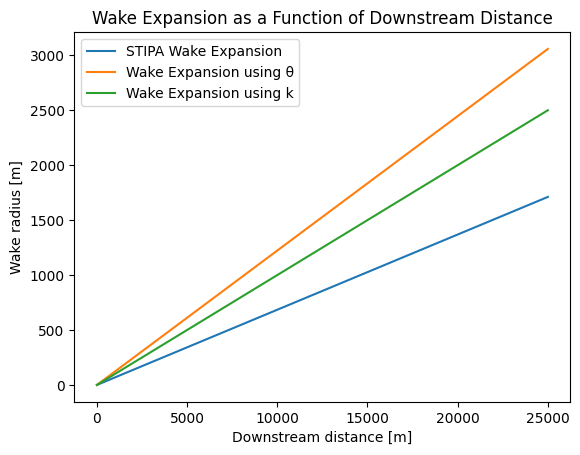

In [219]:
# Wake expansion
x = np.linspace(0, 25000, 25000)

# Wake expansion model from STIPA paper
R_f = n_t_turbine * D + (n_t_turbine-1) * s_y * D # Initial wake radius [m]
alpha = 1 # # Wake expansion factor
u_f = min(U_park_deficit) # Wind velocity at downstream edge of wind farm
k_eff = alpha * u_star_lo/u_f
R_farm_stipa = 2 * ((R_f/2 + k_eff * x) - R_f/2)

# Turbopark / FLORIS
theta = np.deg2rad(3.5)  # can be 2.5 - 5.5 degrees
R_farm_theta = 2 * ((R_f/2 + x * np.tan(theta)) - R_f/2)

R_farm_k = 2 * ((R_f/2 + x * 0.05) - R_f/2) # 0.04 - 0.05

plt.plot(x, R_farm_stipa, label='STIPA Wake Expansion')
plt.plot(x, R_farm_theta, label='Wake Expansion using θ')
plt.plot(x, R_farm_k, label='Wake Expansion using k')
plt.xlabel('Downstream distance [m]')
plt.ylabel('Wake radius [m]')
plt.title('Wake Expansion as a Function of Downstream Distance')
plt.legend()
plt.show()